# PBO learnt on several iterations

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 1
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key, bellman_iterations_key = jax.random.split(key, 5)

# Box over states and actions
max_discrete_state = 5
n_discrete_states = 7
max_discrete_action = 5
n_discrete_actions = 7

gamma = 1
n_weights = 1

# Q function
layers_dimension = [50]
action_range_on_max = max_discrete_action
n_actions_on_max = 50

# PBO trainings
tolerance = 0.1
max_iterations = 10000
batch_size_samples = 20
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.00005, "duration": max_iterations}
max_bellman_iterations = 2

# Visualisation
plot_freq = 200
sleeping_time = 0

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = -0.5264108180999756s + 0.7340433597564697a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.9019700288772583s² + 0.12905049324035645a² + 0.4164412021636963sa


## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_discrete_states * n_discrete_actions
replay_buffer = ReplayBuffer()

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

## Visualize samples

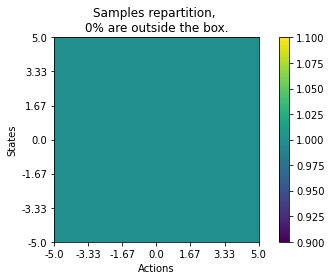

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, discrete_states_boxes, discrete_actions_boxes)
samples_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Optimal Q function

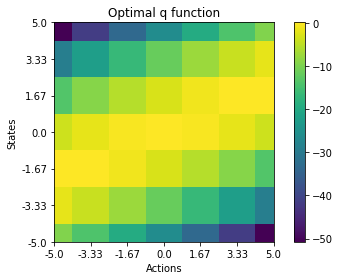

In [5]:
from pbo.utils.compute_Q_lqr import compute_Q_lqr


optimal_q = compute_Q_lqr(env, discrete_states, discrete_actions, gamma)

q_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Build q network

In [6]:
from pbo.networks.q import FullyConnectedQ


q = FullyConnectedQ(
    layers_dimension=layers_dimension,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    action_range_on_max=action_range_on_max,
    n_actions_on_max=n_actions_on_max,
)

## Build PBO network and its dataloaders

In [7]:
from pbo.networks.pbo import LinearPBO
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader


pbo = LinearPBO(pbo_network_key, gamma, q, learning_rate, max_bellman_iterations)

replay_buffer.cast_to_jax_array()
data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)

random_weights_qs = jnp.vstack([q.random_init_weights() for _ in range(n_weights)])
data_loader_weights = WeightsDataLoader(random_weights_qs, batch_size_weights, shuffle_key)

## Train PBO on one iteration

### Define the targets of the random init weights

In [8]:
full_batch = {
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}
target_discrete_iterated_qs = pbo.compute_target(full_batch, data_loader_weights.weights).reshape((n_weights, n_discrete_states, n_discrete_actions))

### Training

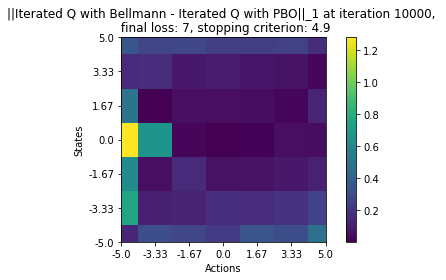

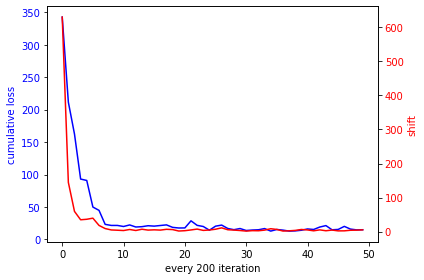

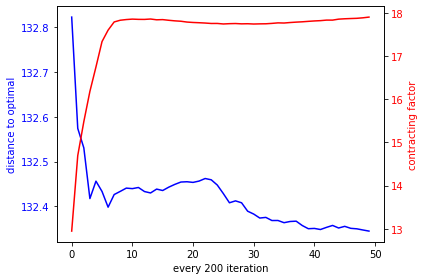

In [9]:
from pbo.utils.shared_axis_plot import shared_axis_plot


# For visualization
former_discrete_iterated_qs = q.discretize(pbo.network.apply(pbo.params, data_loader_weights.weights), discrete_states, discrete_actions)
cumulative_losses = []
shifts = []
optimal_distances = []
contractings = []

iteration = 0
cumulative_loss = float("inf")
stopping_criterion = tolerance * data_loader_samples.n_samples
bellman_iterations = jnp.arange(max_bellman_iterations)

while cumulative_loss > stopping_criterion * data_loader_weights.n_weights * max_bellman_iterations and iteration < max_iterations:
    cumulative_loss = 0
    
    bellman_iterations_key, key = jax.random.split(bellman_iterations_key)
    for n_bellman_iterations in jax.random.permutation(key, bellman_iterations):
        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, loss = pbo.learn_iterations_on_batch(pbo.params, pbo.optimizer_state, batch_samples, batch_weights, int(n_bellman_iterations))
                cumulative_loss += loss

    iteration += 1

    # Visualization
    if iteration % plot_freq == 0:
        discrete_iterated_qs = q.discretize(pbo.network.apply(pbo.params, data_loader_weights.weights), discrete_states, discrete_actions)
        discrete_fix_point_q = q.discretize(pbo.fix_point().reshape((1, -1)), discrete_states, discrete_actions)
        
        shift = jnp.abs(discrete_iterated_qs - former_discrete_iterated_qs).sum(axis=(1, 2)).mean()
        optimal_distance = jnp.linalg.norm(optimal_q - discrete_fix_point_q)
        contracting = pbo.contracting()

        q_visu_mesh.set_values(np.abs(target_discrete_iterated_qs - discrete_iterated_qs).mean(axis=0))
        q_visu_mesh.show(f"||Iterated Q with Bellmann - Iterated Q with PBO||_1 at iteration {iteration}, \nloss: {int(cumulative_loss / data_loader_weights.n_weights / max_bellman_iterations)}, shift: {int(shift)}, stopping criterion: {stopping_criterion}, \ndistance to optimal {int(optimal_distance)}, contracting factor {int(contracting)}")

        cumulative_losses.append(cumulative_loss)
        shifts.append(shift)
        optimal_distances.append(optimal_distance)
        contractings.append(contracting)
        former_discrete_iterated_qs = discrete_iterated_qs

final_discrete_iterated_qs = q.discretize(pbo.network.apply(pbo.params, data_loader_weights.weights), discrete_states, discrete_actions)

q_visu_mesh.set_values(np.abs(target_discrete_iterated_qs - final_discrete_iterated_qs).mean(axis=0))
q_visu_mesh.show(f"||Iterated Q with Bellmann - Iterated Q with PBO||_1 at iteration {iteration}, \n final loss: {int(cumulative_loss / data_loader_weights.n_weights / max_bellman_iterations)}, stopping criterion: {stopping_criterion}")

shared_axis_plot(np.array(cumulative_losses) / data_loader_weights.n_weights, shifts, f"every {plot_freq} iteration", "cumulative loss", "shift")
shared_axis_plot(optimal_distances, contractings, f"every {plot_freq} iteration", "distance to optimal", "contracting factor")

## Validation

### on weights

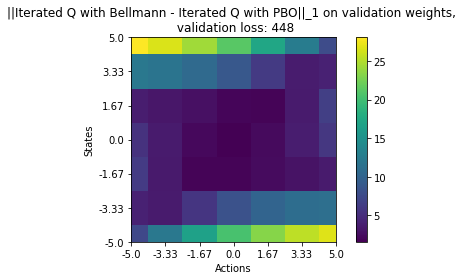

In [10]:
n_weights_val = 500
random_weights_qs_val = jnp.vstack([q.random_init_weights() for _ in range(n_weights_val)])

full_batch = {
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}
target_discrete_iterated_qs_val = pbo.compute_target(full_batch, random_weights_qs_val).reshape((n_weights_val, n_discrete_states, n_discrete_actions))
discrete_iterated_qs_val = q.discretize(pbo.network.apply(pbo.params, random_weights_qs_val), discrete_states, discrete_actions)

validation_loss = np.abs(target_discrete_iterated_qs_val - discrete_iterated_qs_val).sum((1, 2)).mean()

q_visu_mesh.set_values(np.abs(target_discrete_iterated_qs_val - discrete_iterated_qs_val).mean(axis=0))
q_visu_mesh.show(f"||Iterated Q with Bellmann - Iterated Q with PBO||_1 on validation weights, \n validation loss: {int(validation_loss)}")

### on samples

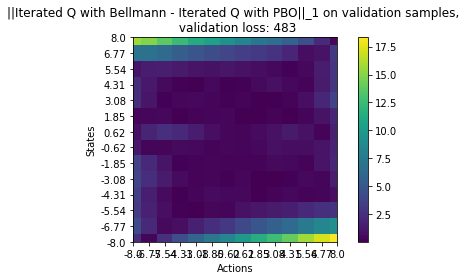

In [11]:
n_discrete_states_val = 2 * n_discrete_states
n_discrete_actions_val = 2 * n_discrete_actions
discrete_states_val = np.linspace(-max_discrete_state - 3, max_discrete_state + 3, n_discrete_states_val)
discrete_actions_val = np.linspace(-max_discrete_action - 3 , max_discrete_action + 3, n_discrete_actions_val)
n_samples_val = n_discrete_states_val * n_discrete_actions_val

q_visu_mesh_val = StateActionMesh(discrete_states_val, discrete_actions_val, sleeping_time)

replay_buffer_val = ReplayBuffer()

for state in discrete_states_val:
    for action in discrete_actions_val:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer_val.add(jnp.array([state]), jnp.array([action]), reward, next_state)
        
        
replay_buffer_val.cast_to_jax_array()

full_batch = {
    "reward": replay_buffer_val.rewards,
    "next_state": replay_buffer_val.next_states,
}
target_discrete_iterated_qs_val = pbo.compute_target(full_batch, random_weights_qs).reshape((n_weights, n_discrete_states_val, n_discrete_actions_val))
discrete_iterated_qs_val = q.discretize(pbo.network.apply(pbo.params, random_weights_qs), discrete_states_val, discrete_actions_val)

validation_loss = np.abs(target_discrete_iterated_qs_val - discrete_iterated_qs_val).sum((1, 2)).mean()

q_visu_mesh_val.set_values(np.abs(target_discrete_iterated_qs_val - discrete_iterated_qs_val).mean(axis=0))
q_visu_mesh_val.show(f"||Iterated Q with Bellmann - Iterated Q with PBO||_1 on validation samples, \n validation loss: {int(validation_loss)}")

### on iterations